<a href="https://colab.research.google.com/github/LuniaKunal/Machine-Learning/blob/main/Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install lightgbm

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/credit-risk-dataset


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, PrecisionRecallDisplay
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier

In [9]:
data_path = '/root/.cache/kagglehub/datasets/laotse/credit-risk-dataset/versions/1/credit_risk_dataset.csv'

In [10]:
df = pd.read_csv(data_path)

In [11]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [13]:
dups = df.duplicated()

In [14]:
df[dups]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15989,23,90000,MORTGAGE,7.0,EDUCATION,B,8000,10.36,0,0.09,N,3
15995,24,48000,MORTGAGE,4.0,MEDICAL,A,4000,5.42,0,0.08,N,4
16025,24,10000,RENT,8.0,PERSONAL,A,3000,7.90,1,0.30,N,3
16028,23,100000,MORTGAGE,7.0,EDUCATION,A,15000,7.88,0,0.15,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32010,42,39996,MORTGAGE,2.0,HOMEIMPROVEMENT,A,2500,5.42,0,0.06,N,12
32047,36,250000,RENT,2.0,DEBTCONSOLIDATION,A,20000,7.88,0,0.08,N,17
32172,49,120000,MORTGAGE,12.0,MEDICAL,B,12000,10.99,0,0.10,N,12
32259,39,40000,OWN,4.0,VENTURE,B,1000,10.37,0,0.03,N,16


In [15]:
df.query("person_age==23 & person_income==42000 & person_home_ownership == 'RENT' & loan_int_rate == 9.99")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
6464,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4
15975,23,42000,RENT,5.0,VENTURE,B,6000,9.99,0,0.14,N,4


In [16]:
df.drop_duplicates(inplace=True)

In [17]:
df.shape

(32416, 12)

In [18]:
df.isna().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3095
loan_status,0
loan_percent_income,0


In [19]:
changed_df = df.dropna()

In [20]:
changed_df.shape
# changed_df.isna().sum()

(28501, 12)

In [30]:
# Stratify is to maintain the same proportion of classes in the train and test set
X_train, X_test, Y_train, Y_test = train_test_split(changed_df.drop('loan_status', axis=1), changed_df['loan_status'], stratify=changed_df['loan_status'],test_size=0.2, random_state=0, shuffle=True)


In [31]:
changed_df['loan_status'].value_counts(normalize=True)

,proportion
loan_status,
0,0.782885
1,0.217115


In [32]:
Y_test.value_counts(normalize=True)

,proportion
loan_status,
0,0.782845
1,0.217155


In [33]:
Y_train.value_counts(normalize=True)

,proportion
loan_status,
0,0.782895
1,0.217105


In [34]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
23275,28,26496,RENT,2.0,MEDICAL,D,5000,14.83,0.19,Y,10
5076,26,37200,MORTGAGE,10.0,DEBTCONSOLIDATION,C,16000,13.11,0.43,N,2
14177,26,135000,RENT,10.0,PERSONAL,B,14275,9.45,0.11,N,2
2245,26,28000,RENT,10.0,MEDICAL,D,13000,16.29,0.46,Y,3
2609,26,33000,RENT,2.0,MEDICAL,B,3000,11.49,0.09,N,3


In [35]:
X_train.drop('loan_percent_income', axis=1, inplace=True)
X_test.drop('loan_percent_income', axis=1, inplace=True)

In [36]:
for col in X_train:
    print(col, '--->', X_train[col].nunique())
    if X_train[col].nunique()<20:
        print(X_train[col].value_counts(normalize=True)*100)
    print()

person_age ---> 55

person_income ---> 3263

person_home_ownership ---> 4
person_home_ownership
RENT        50.833333
MORTGAGE    41.210526
OWN          7.635965
OTHER        0.320175
Name: proportion, dtype: float64

person_emp_length ---> 34

loan_intent ---> 6
loan_intent
EDUCATION            20.052632
MEDICAL              18.368421
VENTURE              17.500000
PERSONAL             17.092105
DEBTCONSOLIDATION    15.776316
HOMEIMPROVEMENT      11.210526
Name: proportion, dtype: float64

loan_grade ---> 7
loan_grade
A    32.644737
B    31.824561
C    20.092105
D    11.355263
E     3.092105
F     0.771930
G     0.219298
Name: proportion, dtype: float64

loan_amnt ---> 683

loan_int_rate ---> 343

cb_person_default_on_file ---> 2
cb_person_default_on_file
N    81.986842
Y    18.013158
Name: proportion, dtype: float64

cb_person_cred_hist_length ---> 29



In [37]:
X_train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,cb_person_cred_hist_length
count,22800.00000,2.280000e+04,22800.000000,22800.000000,22800.000000,22800.000000
mean,27.72250,6.665494e+04,4.797149,9678.706140,11.061897,5.795921
std,6.27985,6.465284e+04,4.171921,6318.807186,3.237360,4.037400
min,20.00000,4.000000e+03,0.000000,500.000000,5.420000,2.000000
25%,23.00000,3.960000e+04,2.000000,5000.000000,7.900000,3.000000
50%,26.00000,5.600000e+04,4.000000,8000.000000,11.030000,4.000000
75%,30.00000,8.000000e+04,7.000000,12500.000000,13.480000,8.000000
max,144.00000,6.000000e+06,123.000000,35000.000000,23.220000,30.000000


In [38]:
num_cols = [col for col in X_train if X_train[col].dtypes != 'O']
num_cols

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'cb_person_cred_hist_length']

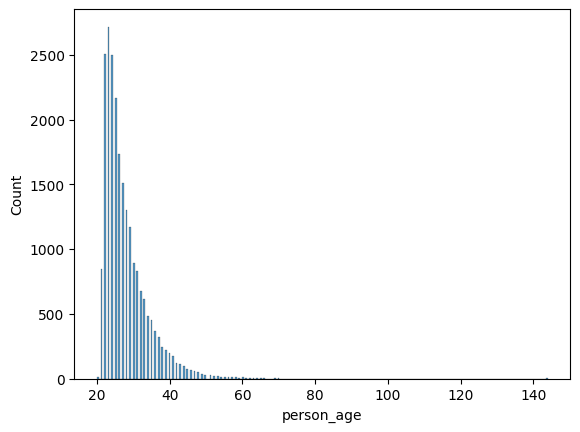

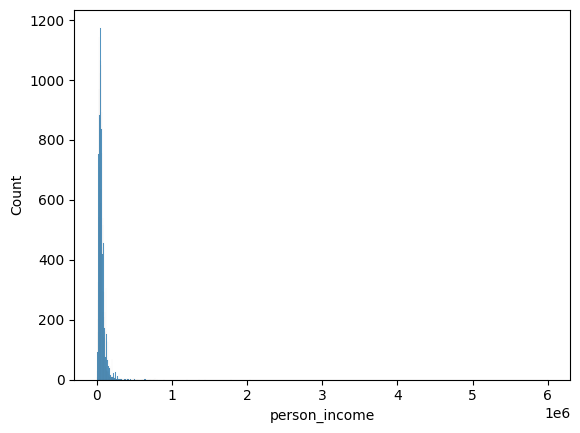

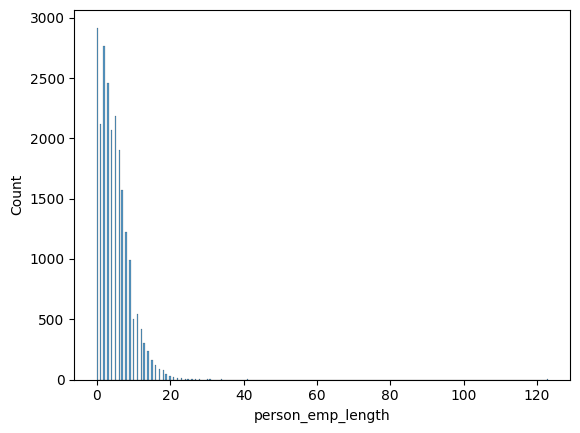

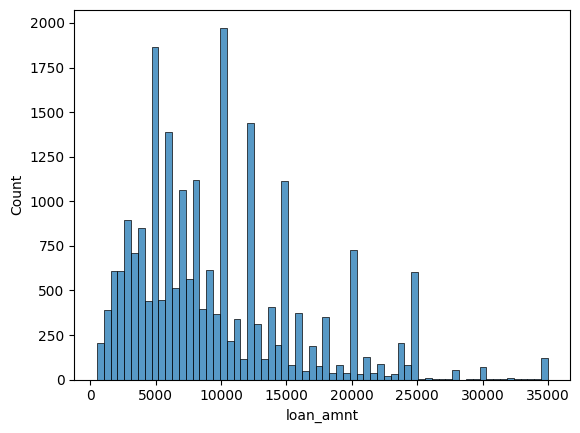

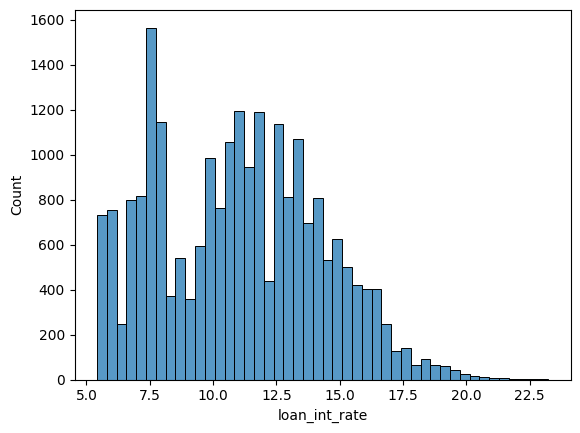

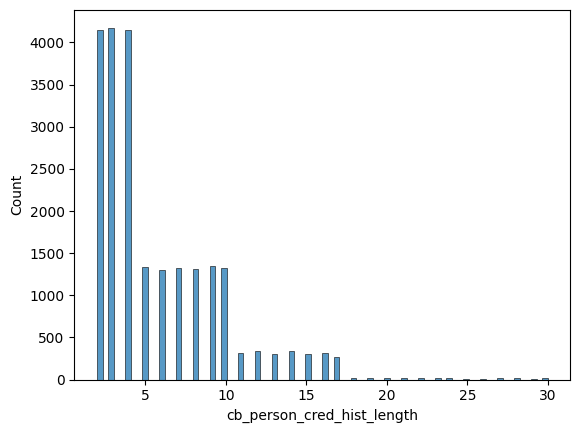

In [39]:
for col in num_cols:
    sns.histplot(X_train[col])
    plt.show()

In [40]:
X_train.loc[X_train['person_age']>=80, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,N,2
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,N,25
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,N,3
32506,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,N,24


In [41]:
X_train = X_train.loc[X_train['person_age']<80, :]

In [42]:
X_train.loc[X_train['person_emp_length']>=66, :]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,cb_person_default_on_file,cb_person_cred_hist_length
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,N,4
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,Y,3


In [43]:
X_train = X_train.loc[(X_train['person_emp_length']<66) | (X_train['person_emp_length'].isna()), :]

In [44]:
Y_train = Y_train[X_train.index]

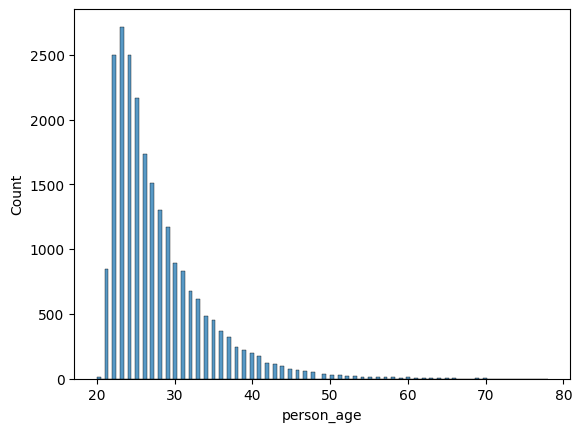

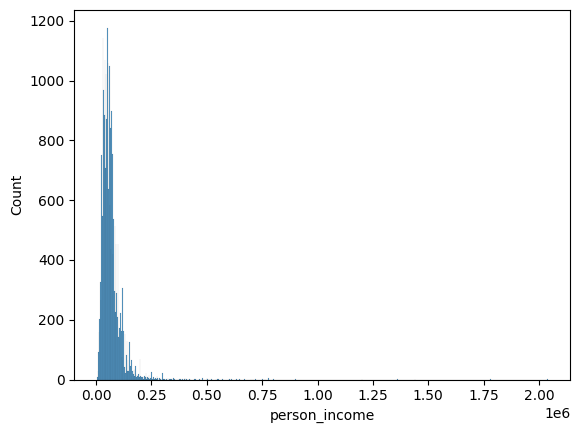

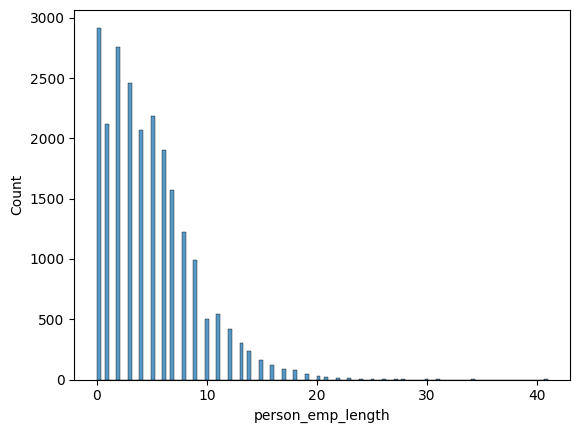

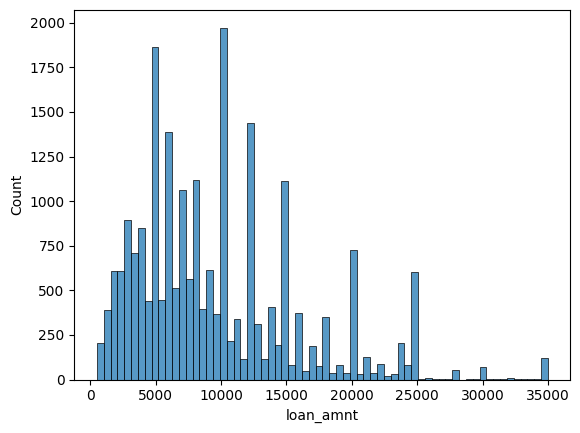

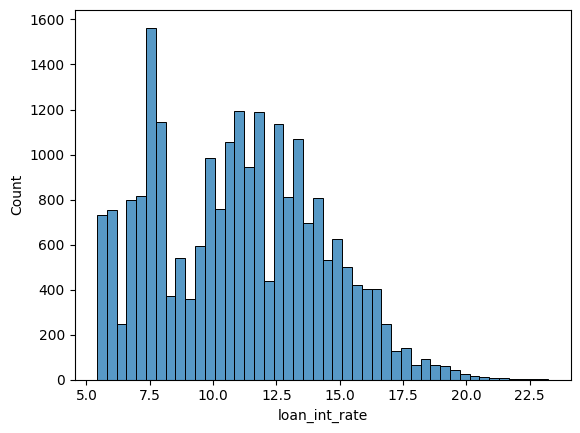

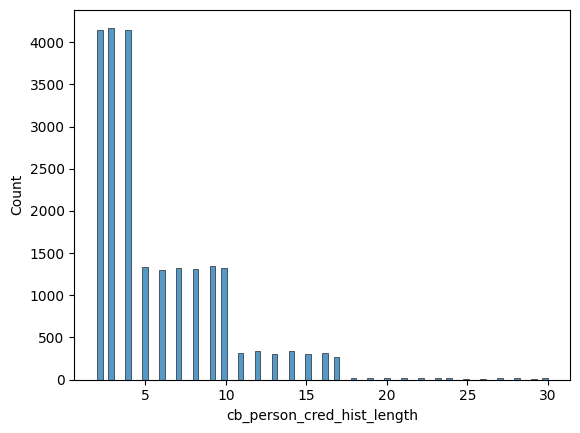

In [53]:
for col in num_cols:
    sns.histplot(X_train[col])
    plt.show()

In [45]:
cat_cols = [col for col in X_train if X_train[col].dtypes == 'O']
cat_cols

['person_home_ownership',
 'loan_intent',
 'loan_grade',
 'cb_person_default_on_file']

## Completed Data Cleaning

In [46]:
num_pipe = Pipeline([
    ('impute', IterativeImputer()),
    ('scale', StandardScaler()),
])

In [49]:
ct = ColumnTransformer([
    ('num_pipe', num_pipe, num_cols),
    ('cat_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

In [50]:
num_pipe

Pipeline(steps=[('impute', IterativeImputer()), ('scale', StandardScaler())])

In [51]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_pipe',
                                 Pipeline(steps=[('impute', IterativeImputer()),
                                                 ('scale', StandardScaler())]),
                                 ['person_age', 'person_income',
                                  'person_emp_length', 'loan_amnt',
                                  'loan_int_rate',
                                  'cb_person_cred_hist_length']),
                                ('cat_cols',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['person_home_ownership', 'loan_intent',
                                  'loan_grade', 'cb_person_default_on_file'])])

In [52]:
grid = {
    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[300,400,500],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},

    LGBMClassifier(class_weight='balanced', random_state=0, n_jobs=-1):
    {'model__n_estimators':[300,400,500],
     'model__learning_rate':[0.001,0.01,0.1,1,10],
     'model__boosting_type': ['gbdt', 'goss', 'dart'],
     'coltf__num_pipe__impute__estimator':[LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]},
}

In [54]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}


LGBMClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [300, 400, 500], 'model__learning_rate': [0.001, 0.01, 0.1, 1, 10], 'model__boosting_type': ['gbdt', 'goss', 'dart'], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [55]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4, random_state=0)

    gs.fit(X_train, Y_train)

    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name

    full_df = pd.concat([full_df, temp], ignore_index=True)
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 4949, number of negative: 17845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 896
[LightGBM] [Info] Number of data points in the train set: 22794, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [56]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
1,"{'model__n_estimators': 500, 'coltf__num_pipe_...",0.923357,RandomForestClassifier
0,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.923269,RandomForestClassifier
2,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.923269,RandomForestClassifier
3,"{'model__n_estimators': 400, 'coltf__num_pipe_...",0.923269,RandomForestClassifier
7,"{'model__n_estimators': 300, 'model__learning_...",0.906291,LGBMClassifier
5,"{'model__n_estimators': 300, 'model__learning_...",0.875801,LGBMClassifier
4,"{'model__n_estimators': 300, 'model__learning_...",0.869351,LGBMClassifier
6,"{'model__n_estimators': 300, 'model__learning_...",0.867465,LGBMClassifier


In [57]:
full_df.sort_values('mean_test_score', ascending=False).iloc[0, 0]

{'model__n_estimators': 500,
 'coltf__num_pipe__impute__estimator': LinearRegression()}

In [58]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        random_state=0))])

In [60]:
be.fit(X_train, Y_train)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        random_state=0))])

In [61]:
preds = be.predict(X_test)

In [63]:
confusion_matrix(Y_test, preds)

array([[4411,   52],
       [ 365,  873]])

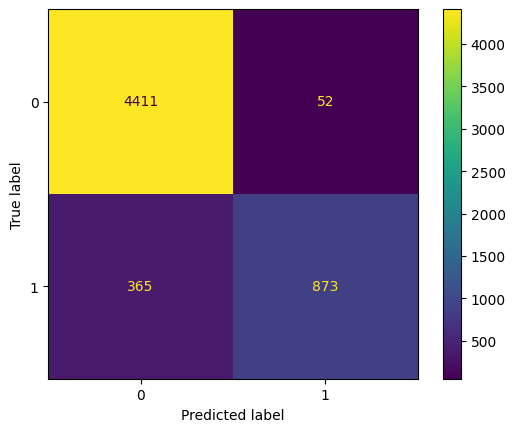

In [70]:
# Instead of plot_confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, preds), display_labels=be.classes_)
disp.plot()
plt.show()

In [72]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4463
           1       0.94      0.71      0.81      1238

    accuracy                           0.93      5701
   macro avg       0.93      0.85      0.88      5701
weighted avg       0.93      0.93      0.92      5701



In [74]:
be.score(X_test, Y_test)

0.9268549377302228

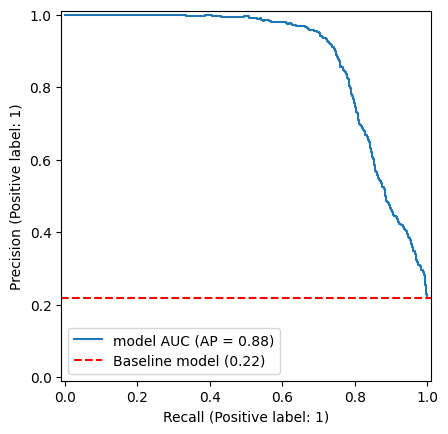

In [77]:
display = PrecisionRecallDisplay.from_estimator(estimator=be, X=X_test, y=Y_test, name='model AUC')
baseline = Y_test.sum() / len(Y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

In [79]:
a, b, c = learning_curve(be, X_train, Y_train, n_jobs=-1, scoring='accuracy')

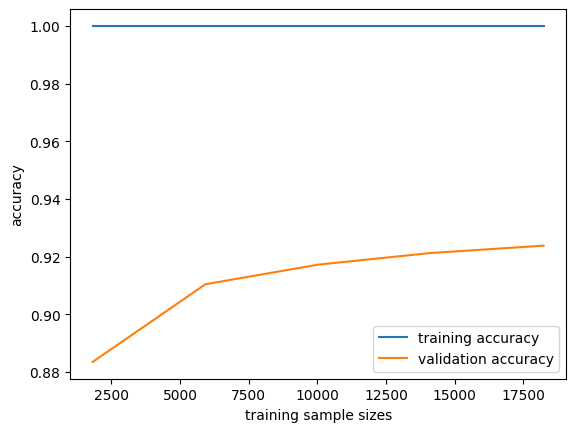

In [80]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()

# Overfitting:
1. High training accuracy (--- low bias)
2. Low testing/ validation accuracy (--- high variance)
3. Big gap between training and validation curves (--- high variance)
4. Overfitting makes a very complex model and learns even the "noise" in the data, which is undesirable

In [81]:
grid = {

    RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced'):
    {'model__n_estimators':[100,200,300],
     'model__max_depth':[5, 9, 13],
     'model__min_samples_split':[4,6,8],
     'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0),
                                        KNeighborsRegressor()]} }

In [82]:
for clf, param in grid.items():
    print(clf)
    print('-'*50)
    print(param)
    print('\n')

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)
--------------------------------------------------
{'model__n_estimators': [100, 200, 300], 'model__max_depth': [5, 9, 13], 'model__min_samples_split': [4, 6, 8], 'coltf__num_pipe__impute__estimator': [LinearRegression(), RandomForestRegressor(random_state=0), KNeighborsRegressor()]}




In [83]:
full_df = pd.DataFrame()
best_algos = {}

for clf, param in grid.items():
    pipe = Pipeline([
    ('coltf', ct),
    ('model', clf)
])

    gs = RandomizedSearchCV(estimator=pipe, param_distributions=param, scoring='accuracy',
                            n_jobs=-1, verbose=3, n_iter=4)

    gs.fit(X_train, Y_train)

    all_res = pd.DataFrame(gs.cv_results_)

    temp = all_res.loc[:, ['params', 'mean_test_score']]
    algo_name = str(clf).split('(')[0]
    temp['algo'] = algo_name

    full_df = pd.concat([full_df, temp])
    best_algos[algo_name] = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [84]:
full_df.sort_values('mean_test_score', ascending=False)

,params,mean_test_score,algo
3,"{'model__n_estimators': 100, 'model__min_sampl...",0.908441,RandomForestClassifier
2,"{'model__n_estimators': 100, 'model__min_sampl...",0.868650,RandomForestClassifier
0,"{'model__n_estimators': 300, 'model__min_sampl...",0.865359,RandomForestClassifier
1,"{'model__n_estimators': 300, 'model__min_sampl...",0.812056,RandomForestClassifier


In [85]:
be = best_algos['RandomForestClassifier']
be

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        min_samples_split=6, n_jobs=-1,
                                        random_state=0))])

In [86]:
be.fit(X_train, Y_train)

Pipeline(steps=[('coltf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipe',
                                                  Pipeline(steps=[('impute',
                                                                   IterativeImputer(estimator=LinearRegression())),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['person_home_ownership',
                                                   'loan_intent', 'loan_grade',
                                                   'cb_person_default_on_file'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=13,
                                        min_samples_split=6, n_jobs=-1,
                                        random_state=0))])

In [87]:
preds = be.predict(X_test)

In [88]:
confusion_matrix(Y_test, preds)

array([[4280,  183],
       [ 293,  945]])

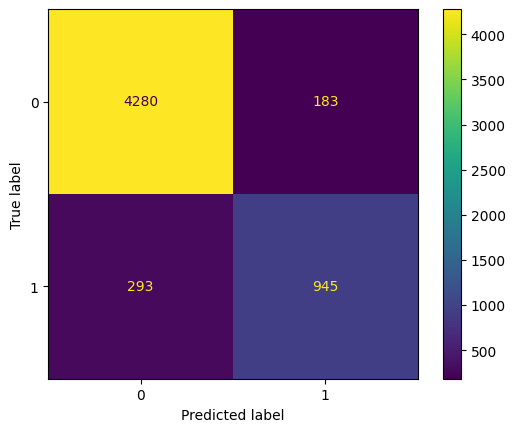

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_test, preds), display_labels=be.classes_)
disp.plot()
plt.show()

In [90]:
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4463
           1       0.84      0.76      0.80      1238

    accuracy                           0.92      5701
   macro avg       0.89      0.86      0.87      5701
weighted avg       0.91      0.92      0.92      5701



In [91]:
be.score(X_test, Y_test)

0.9165058761620768

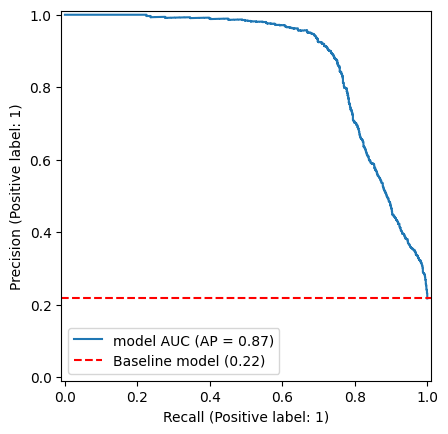

In [92]:
display = PrecisionRecallDisplay.from_estimator(estimator=be, X=X_test, y=Y_test, name='model AUC')
baseline = Y_test.sum() / len(Y_test)
plt.axhline(baseline, ls='--', color='r', label=f'Baseline model ({round(baseline,2)})')
plt.legend(loc='best')

In [93]:
a, b, c = learning_curve(be, X_train, Y_train, n_jobs=-1, scoring='accuracy')

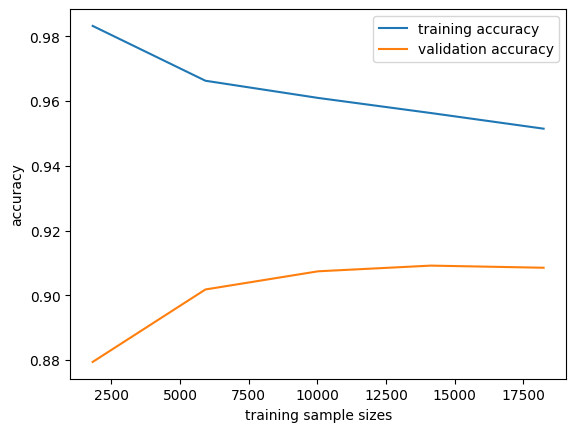

In [94]:
plt.plot(a, b.mean(axis=1), label='training accuracy')
plt.plot(a, c.mean(axis=1),  label='validation accuracy')
plt.xlabel('training sample sizes')
plt.ylabel('accuracy')
plt.legend()